In [86]:
from data_processing_try import *
from train_trace_3 import *
from visualization import print_segment_with_delta_values

### load data

merging the data sets...
calculate the quaternion representations...
calculate the rotation matrices...
calculate the navigation frame representation...
integrate the acceleration...


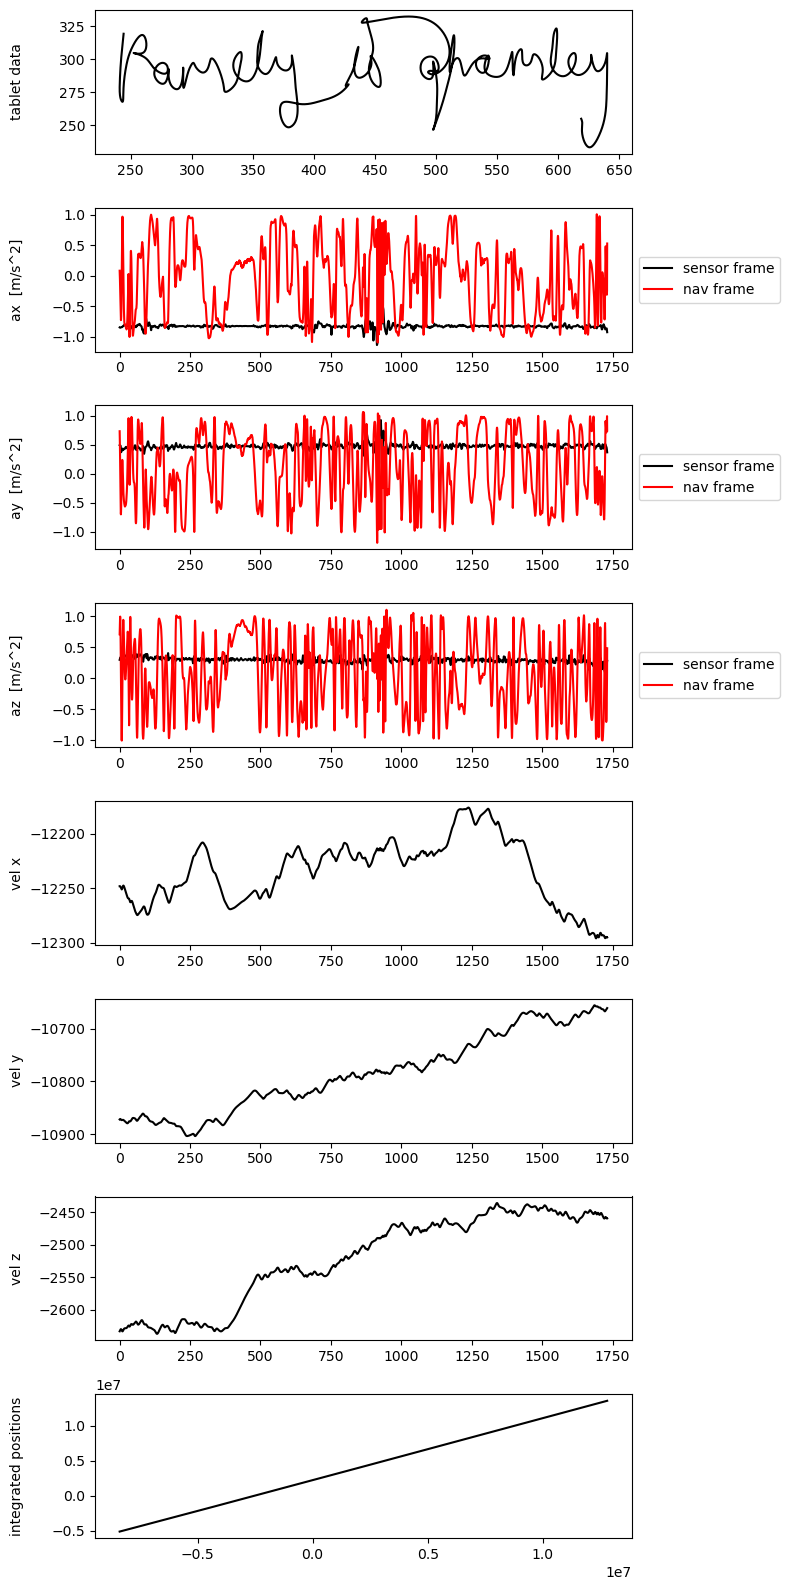

In [87]:
data = Dataset("set1_imu.csv", "set1_tab.csv")
data.data_set.to_csv("./data/data_frame_smooth.csv")
data = data.data_set
plot_ith_segment(data, 47)

In [88]:

#df = pd.read_csv("./data/data_frame_smooth.csv")
#data = df
# get start indices for the different segments (here a segment represents a sentence)
segment_starts = data[data["segment"].diff() != 0].index.tolist()
# so that dx at index i represents the difference to i+1
data["dx"] = data["dx"].shift(-1)
data["dy"] = data["dy"].shift(-1)

num_segments = data["segment"].iloc[-1]
feature_columns = ["ax", "ay", "az", "vel_x", "vel_y", "vel_z", "gx", "gy", "gz", "q0", "q1", "q2", "q3"]
label_columns = ["dx", "dy"]

INPUT_DIM = 13
OUTPUT_DIM = 2 


data.head()


,t_r,x,y,z,ax,ay,az,gx,gy,gz,...,nav_ay,nav_az,vel_x,vel_y,vel_z,pos_x,pos_y,pos_z,dx,dy
0,0.0,171.081563,175.444042,0.0,-0.846652,0.333538,0.358858,0.030683,-0.051090,-0.443710,...,-0.256070,-0.643924,0.000000,0.000000,0.000000,171.081563,175.444042,0.000000,-0.932889,-0.824417
1,0.5,170.148674,174.619624,0.0,-0.863770,0.266961,0.328226,-0.098304,-0.025454,-0.393085,...,-0.354587,-0.658915,-0.323676,-0.152664,-0.325710,171.000643,175.405875,-0.081427,-0.858081,-0.730112
2,1.0,169.290593,173.889512,0.0,-0.878953,0.216098,0.305050,-0.191155,-0.007150,-0.326313,...,-0.417381,-0.650395,-0.615088,-0.345656,-0.653037,170.765953,175.281295,-0.326114,-0.786073,-0.639797
3,1.5,168.504520,173.249715,0.0,-0.882562,0.259232,0.326468,-0.067845,-0.032703,-0.162954,...,-0.398371,-0.645887,-0.908885,-0.549594,-0.977108,170.384959,175.057483,-0.733650,-0.716863,-0.553470
4,2.0,167.787657,172.696245,0.0,-0.885694,0.302587,0.341227,0.028487,-0.045747,-0.035403,...,-0.375734,-0.645659,-1.227123,-0.743121,-1.299994,169.850957,174.734304,-1.302926,-0.650453,-0.471133


### visualize a sentence with the delta values

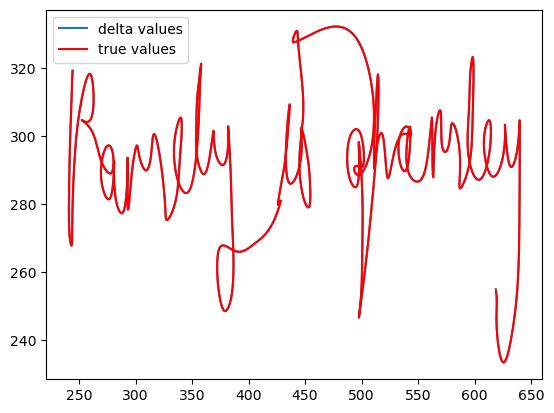

In [89]:

# choose random segment
segment = data[data["segment"] == 47]
segment_indices = list(range(segment_starts[47], segment_starts[48]-1))
segment_47 = data[data["segment"] == 47].index.tolist()

#print_segment_with_delta_values(segment.loc[segment.index[0], "x"], segment.loc[segment.index[0], "y"], segment.loc[segment.index[1:], "dx"].values, segment.loc[segment.index[1:], "dy"].values, segment.loc[segment.index[0:], "x"].values, segment.loc[segment.index[0:], "y"].values)
print_segment_with_delta_values(data.loc[segment_starts[47], "x"], data.loc[segment_starts[47], "y"], data.loc[segment_indices, "dx"].values, data.loc[segment_indices, "dy"].values, data.loc[segment_indices, "x"].values, data.loc[segment_indices, "y"].values)

### shape input and create batches


#### 1. approach: small batches not overlapping

In [5]:
TIME_STEMPS = 10
OFFSET = 10 # if offset < timesteps I have overlapping

# shape data into (batches, timestemps, features)
def create_segments_and_labels(dataframe: pd.DataFrame, steps, offset):
        dataframe = dataframe[dataframe.columns.intersection(feature_columns + label_columns)]
        segments = []
        labels = []
        # how many full batches can I create 
        num_batches = int((dataframe.shape[0] * INPUT_DIM) / (steps * (INPUT_DIM)))
        i = 0
        for b in range(num_batches):
            segments.append(dataframe.iloc[i: i+steps, :-2].to_numpy().flatten().tolist())
            labels.append(dataframe.iloc[i:i+steps, -2:].to_numpy().flatten().tolist()) 
            i = i + offset
        x, y = np.array(segments).reshape(-1,steps, INPUT_DIM), np.array(labels).reshape(-1,steps, OUTPUT_DIM)
        
        print("reshaped labels shape: ",y.shape, "reshaped segments shape: ", x.shape)
        return x, y


#### 2. approach: small batches overlapping

In [90]:
TIME_STEMPS = 20
OFFSET = 10 # if offset < timesteps I have overlapping

# shape data into (batches, timestemps, features)
def create_segments_and_labels(dataframe: pd.DataFrame, steps, offset):
        dataframe = dataframe[dataframe.columns.intersection(feature_columns + label_columns)]
        segments = []
        labels = []
        # how many full batches can I create 
        num_batches = int((dataframe.shape[0] * INPUT_DIM) / (steps * (INPUT_DIM)))
        i = 0
        for b in range(num_batches):
            segments.append(dataframe.iloc[i: i+steps, :-2].to_numpy().flatten().tolist())
            labels.append(dataframe.iloc[i:i+steps, -2:].to_numpy().flatten().tolist()) 
            i = i + offset
        x, y = np.array(segments).reshape(-1,steps, INPUT_DIM), np.array(labels).reshape(-1,steps, OUTPUT_DIM)
        
        print("reshaped labels shape: ",y.shape, "reshaped segments shape: ", x.shape)
        return x, y


#### 3. approach large batches not overlapping

In [7]:
TIME_STEMPS = 500
OFFSET = 500 # if offset < timesteps I have overlapping

# shape data into (batches, timestemps, features)
def create_segments_and_labels(dataframe: pd.DataFrame, steps, offset):
        dataframe = dataframe[dataframe.columns.intersection(feature_columns + label_columns)]
        segments = []
        labels = []
        # how many full batches can I create 
        num_batches = int((dataframe.shape[0] * INPUT_DIM) / (steps * (INPUT_DIM)))
        i = 0
        for b in range(num_batches):
            segments.append(dataframe.iloc[i: i+steps, :-2].to_numpy().flatten().tolist())
            labels.append(dataframe.iloc[i:i+steps, -2:].to_numpy().flatten().tolist()) 
            i = i + offset
        x, y = np.array(segments).reshape(-1,steps, INPUT_DIM), np.array(labels).reshape(-1,steps, OUTPUT_DIM)
        
        print("reshaped labels shape: ",y.shape, "reshaped segments shape: ", x.shape)
        return x, y

#### 4. approach: large batches overlapping

In [39]:
TIME_STEMPS = 500
OFFSET = 100 # if offset < timesteps I have overlapping

# shape data into (batches, timestemps, features)
def create_segments_and_labels(dataframe: pd.DataFrame, steps, offset):
        dataframe = dataframe[dataframe.columns.intersection(feature_columns + label_columns)]
        segments = []
        labels = []
        # how many full batches can I create 
        num_batches = int((dataframe.shape[0] * INPUT_DIM) / (steps * (INPUT_DIM)))
        i = 0
        for b in range(num_batches):
            segments.append(dataframe.iloc[i: i+steps, :-2].to_numpy().flatten().tolist())
            labels.append(dataframe.iloc[i:i+steps, -2:].to_numpy().flatten().tolist()) 
            i = i + offset
        x, y = np.array(segments).reshape(-1,steps, INPUT_DIM), np.array(labels).reshape(-1,steps, OUTPUT_DIM)
        
        print("reshaped labels shape: ",y.shape, "reshaped segments shape: ", x.shape)
        return x, y

### 5. approach: batches according to sentences

In [59]:
PAD_VALUE = 999
def create_segments_and_labels(dataframe: pd.DataFrame):
        LENGTH_SEGMENT = np.max(dataframe.groupby("segment").size())
        num_batches = dataframe.loc[len(dataframe)-1, "segment"]
        #dataframe = dataframe[dataframe.columns.intersection(feature_columns + label_columns)]
        segments = []
        labels = []

        for i in range(num_batches):
            d_i = dataframe[dataframe["segment"] == i]
            features = d_i.loc[:, feature_columns].to_numpy().flatten().tolist()
            delta_values = d_i.loc[:,label_columns].to_numpy().flatten().tolist() 

            segments.append(features)
            labels.append(delta_values)

        x_train = tf.keras.preprocessing.sequence.pad_sequences(segments, padding="post", value=PAD_VALUE, maxlen= LENGTH_SEGMENT * INPUT_DIM)
        x_train = np.asarray(x_train, dtype= np.float32).reshape(num_batches,-1, INPUT_DIM)

        y_train = tf.keras.preprocessing.sequence.pad_sequences(labels, padding="post", value=PAD_VALUE, maxlen= LENGTH_SEGMENT * OUTPUT_DIM)
        y_train = np.asarray(y_train, dtype= np.float32).reshape(num_batches,-1, OUTPUT_DIM)
        
        print("reshaped labels shape: ",y_train.shape, "reshaped X shape: ", x_train.shape)
        return x_train, y_train

#### split into trainings and test data

In [91]:
def prepare_data_with_segments(df, test_split = 0.2,):
        print ('Split into test and trainings data...')
        scaler = StandardScaler() 
        df[feature_columns] = pd.DataFrame(scaler.fit_transform(df[feature_columns].values), index=df.index)

        split = int(num_segments * (1- test_split))
        train_data = df[df["segment"] <= split]
        # use single segment for test data for now
        test_data = data.iloc[segment_indices]

        x_train, y_train = create_segments_and_labels(train_data, TIME_STEMPS, OFFSET) #, TIME_STEMPS, OFFSET

        x_train = x_train.astype('float32')
        y_train = y_train.astype('float32')

        return x_train, y_train


# create training and test data
x_train, y_train= prepare_data_with_segments(data)

Split into test and trainings data...
reshaped labels shape:  (8275, 20, 2) reshaped segments shape:  (8275, 20, 13)


#### first model


In [11]:
def def_model_0(time_stemps, num_features=INPUT_DIM):
        inp = tf.keras.layers.Input((time_stemps,num_features))
        #x = tf.keras.layers.Masking(mask_value=self.PAD_VALUE)(inp)
        x = tf.keras.layers.LSTM(128, return_sequences=True)(inp)
        #x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64))(x) #TimeDistributed(
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
        #x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(OUTPUT_DIM))(x)

        model = tf.keras.Model(inp, x)
        tf.keras.Model()
        return model

#### model for sentence batching

In [12]:
# use TimeDistributed Layer for sentence segmentation: This wrapper allows to apply a layer to every temporal slice of an input.

#### model for CNN_LSTM

In [92]:
from tensorflow import keras
from keras import layers

def def_model_1(time_stemps, num_features=INPUT_DIM):
        inp = tf.keras.layers.Input((time_stemps,num_features))
        x = tf.keras.layers.Conv1D(32, kernel_size=32)(inp)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Conv1D(32, kernel_size=16)(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=64, padding="same")(x)
        x = tf.keras.layers.Conv1D(16, kernel_size=8)(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
        x = tf.keras.layers.Dense(OUTPUT_DIM)(x)

        model = tf.keras.Model(inp, x)
        tf.keras.Model()
        return model

def def_model_2(time_stemps, num_features=INPUT_DIM):
        model = Sequential()
        model.add(tf.keras.layers.Input((time_stemps,num_features))) 
        model.add(tf.keras.layers.Conv1D(filters=100, kernel_size=2, activation='relu', padding="same"))  #tf.keras.layers.TimeDistributed(
        model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=6, activation='relu', padding="same")) #tf.keras.layers.TimeDistributed(
        model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5)))
        model.add(tf.keras.layers.MaxPooling1D(pool_size=3, padding="same")) #tf.keras.layers.TimeDistributed(
        model.add(tf.keras.layers.LSTM(100))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(OUTPUT_DIM))
        return model


def def_model_3(num_features=INPUT_DIM):
        model = Sequential()
        model.add(layers.Input((None,num_features))) # none for timestamps
        model.add(layers.Conv1D(filters= 512, kernel_size=5, activation="relu", padding="same")) 
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.1))
        model.add(layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding="same"))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.1))
        model.add(layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding="same"))
        model.add(layers.BatchNormalization())
        #model.add(layers.MaxPooling1D(2))
        model.add(layers.Dropout(0.1))
        model.add(layers.Bidirectional(layers.LSTM(64, activation="tanh", return_sequences=True)))
        model.add(layers.Dropout(0.1))
        model.add(layers.Bidirectional(layers.LSTM(64, activation="tanh", return_sequences=True)))
        model.add(layers.Dense(OUTPUT_DIM))
        return model


The trainings data is of shape (8275, 20, 13) and (8275, 20, 2)
Fitting model...
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_34 (Conv1D)          (None, None, 512)         33792     
                                                                 
 batch_normalization_34 (Bat  (None, None, 512)        2048      
 chNormalization)                                                
                                                                 
 dropout_46 (Dropout)        (None, None, 512)         0         
                                                                 
 conv1d_35 (Conv1D)          (None, None, 256)         393472    
                                                                 
 batch_normalization_35 (Bat  (None, None, 256)        1024      
 chNormalization)                                                
                                      

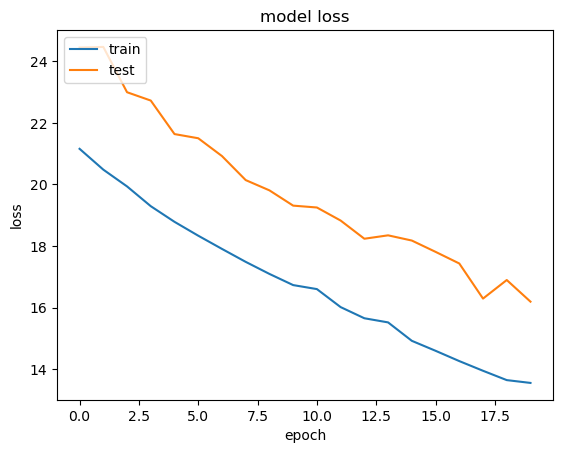

In [93]:
print("The trainings data is of shape {} and {}". format(x_train.shape, y_train.shape))
print ('Fitting model...')

model = def_model_3(INPUT_DIM) 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
print(model.summary())

# train on one segment to verify model for simple input
segment_x = np.expand_dims(segment[segment.columns.intersection(feature_columns)], 1).astype('float32')
segment_y = np.expand_dims(segment[segment.columns.intersection(label_columns)],1).astype('float32')

history = model.fit(x_train, y_train, epochs= 20,batch_size= 100, validation_split=0.2)
#history = model.fit(segment_x, segment_y, epochs= 20,batch_size= 100, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [94]:
segment_x = np.expand_dims(segment[segment.columns.intersection(feature_columns)], 1).astype('float32')
segment_y = segment[segment.columns.intersection(label_columns)].astype('float32')

print("Test data is of shape {} and {}".format(segment_x.shape, segment_y.shape))

Test data is of shape (3463, 1, 13) and (3463, 2)


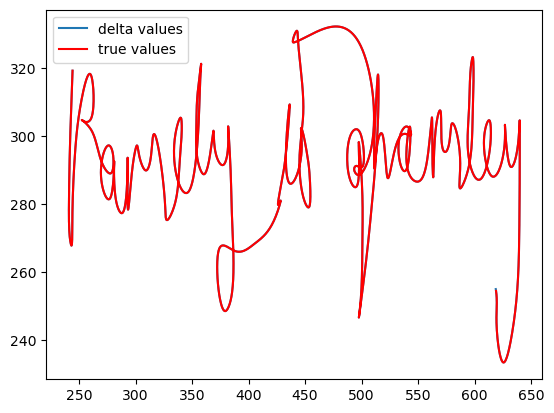

In [95]:
# check if y_test is correctly created and can be reshaped to be compared to original data
print_segment_with_delta_values(data.loc[segment_starts[47], "x"], data.loc[segment_starts[47], "y"], segment_y.iloc[:-1,0].values, segment_y.iloc[:-1,1].values, data.loc[segment_indices, "x"].values, data.loc[segment_indices, "y"].values)

In [96]:
y_pred = model.predict(segment_x, batch_size=100)
print(y_pred.shape)

35/35 [==============================] - 2s 11ms/step
(3463, 1, 2)


In [97]:
start_x = data.loc[segment_starts[47], "x"]
start_y = data.loc[segment_starts[47], "y"]

y_pred = np.squeeze(y_pred, 1)

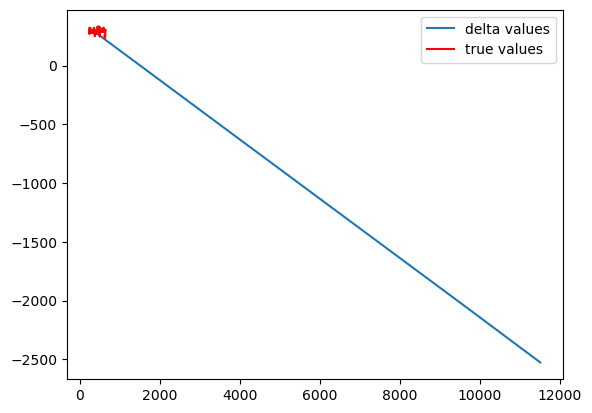

In [100]:
x_values = [start_x]
y_values = [start_y]
for i in range(0,len(segment_y)-2): # 0 statt 1
    x_values.append(x_values[i] + segment_y.iloc[i,0]) # minus 1 bei values weggenommmen
    y_values.append(y_values[i] + segment_y.iloc[i,1])
# bei pred bei 0 angefangen
print_segment_with_delta_values(start_x, start_y, y_pred[:-1,0], y_pred[:-1,1], x_values, y_values)

#### loss function (for segmentation for labeling handwriting sequences)
The CTC is an RNN loss function that enables labeling whole sequences at once. It uses the network to provide direct mapping from an input sequence to an output label
without the need of segmenting the data. It introduces a ‘blank’ character that
is used to find the best alignment of characters that best interprets the input.
(https://arxiv.org/pdf/2105.12434.pdf)
https://keras.io/examples/audio/ctc_asr/

